In [1]:
!pip install yfinance==0.2.18 \
             pandas==1.5.3 \
             numpy==1.24.2 \
             matplotlib==3.7.1 \
             scikit-learn==1.2.2 \
             tensorflow==2.13.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 26.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling n

[*********************100%***********************]  1 of 1 completed
                 Close
Date                  
2020-10-13  121.050003
2020-10-14  119.970001
2020-10-15  119.107002
2020-10-16  118.500000
2020-10-19  116.449997
Fechas del dataset: 2020-10-13 00:00:00 -> 2024-12-31 00:00:00
Total de días descargados: 1061
Dimensiones X_all: (1001, 60)
Dimensiones y_all: (1001,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 128)           66560     
                                                                 
 dropout_8 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 96)                86400     
                                                                 
 dropout_9 (Dropout)         (None, 96)                0         
  

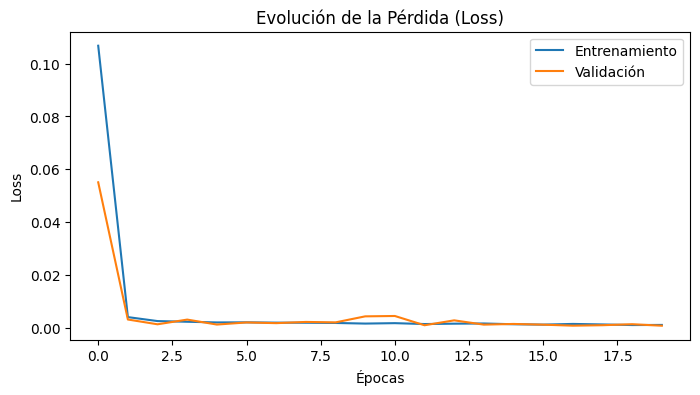

7/7 [==============================] - 1s 41ms/step


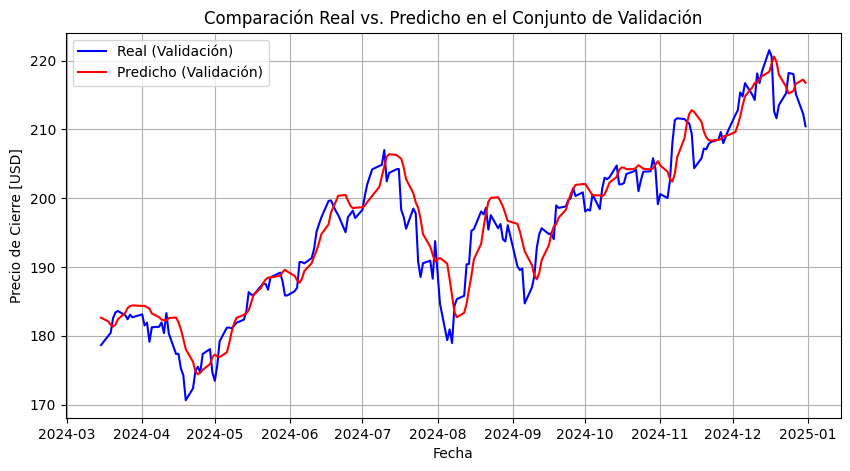

1/1 [==============================] - 0s 33ms/step


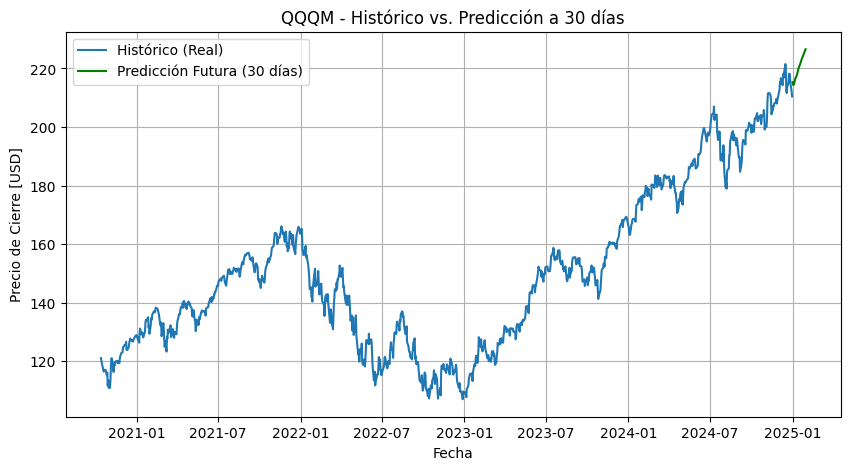

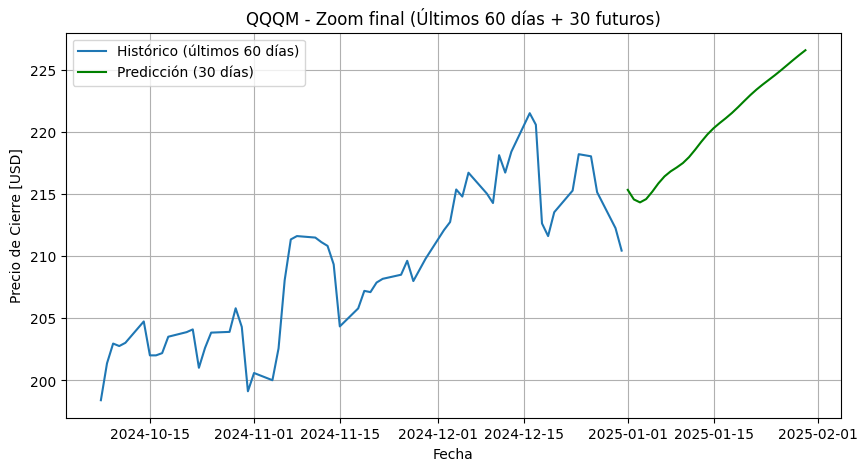

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# =============================================
# 1. DESCARGA DE DATOS HISTÓRICOS
# =============================================
ticker = "QQQM"
start_date = "2020-01-01"
end_date = "2025-01-01"

df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close']].copy()
df.dropna(inplace=True)

print(df.head())
print("Fechas del dataset:", df.index.min(), "->", df.index.max())
print("Total de días descargados:", df.shape[0])

# =============================================
# 2. ESCALADO DE LA SERIE
# =============================================
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']])

# =============================================
# 3. CREACIÓN DE SECUENCIAS (VENTANA DE 60 DÍAS)
# =============================================
def create_sequences(dataset, window_size=60):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i - window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X_all, y_all = create_sequences(scaled_data, window_size=window_size)

print("Dimensiones X_all:", X_all.shape)
print("Dimensiones y_all:", y_all.shape)

# =============================================
# 4. SEPARACIÓN EN ENTRENAMIENTO Y VALIDACIÓN
#    (por ejemplo, 80% - 20%)
# =============================================
train_size = int(len(X_all)*0.8)
X_train, X_val = X_all[:train_size], X_all[train_size:]
y_train, y_val = y_all[:train_size], y_all[train_size:]

# Reshape para que LSTM procese (samples, timesteps, features=1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# =============================================
# 5. CONSTRUCCIÓN DEL MODELO LSTM
# =============================================
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window_size,1)))
model.add(Dropout(0.1))
model.add(LSTM(96, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.summary()

# =============================================
# 6. ENTRENAMIENTO
# =============================================
epochs = 20
batch_size = 32

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1
)

# (Opcional) Visualizamos la evolución de la pérdida
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la Pérdida (Loss)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

# =============================================
# 7. PREDICCIONES EN EL CONJUNTO DE VALIDACIÓN
#    (Aquí sí tenemos datos reales para comparar)
# =============================================
pred_val = model.predict(X_val)
pred_val_inv = scaler.inverse_transform(pred_val)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))

# Indices para graficar la parte de validación
# Recordemos que la primera ventana empieza en 'window_size'.
val_index_start = window_size + train_size  # el primer punto que corresponde a la validación
val_index_end = window_size + train_size + len(y_val)

val_dates = df.index[val_index_start: val_index_end]

# Gráfico: "REAL vs PREDICHO" en validación
plt.figure(figsize=(10,5))
plt.plot(val_dates, y_val_inv, label="Real (Validación)", color='blue')
plt.plot(val_dates, pred_val_inv, label="Predicho (Validación)", color='red')
plt.title("Comparación Real vs. Predicho en el Conjunto de Validación")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre [USD]")
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# 8. PREDICCIÓN DE LOS SIGUIENTES 30 DÍAS
#    (No tenemos datos reales futuros, sólo pronóstico)
# =============================================
future_days = 30
# Tomar la última ventana de 60 días del dataset para arrancar
last_window = scaled_data[-window_size:]

predictions_scaled = []
current_window = last_window.copy()

for _ in range(future_days):
    current_window_reshaped = current_window.reshape((1, window_size, 1))
    next_scaled = model.predict(current_window_reshaped)[0, 0]
    predictions_scaled.append(next_scaled)
    # Deslizamos la ventana: descartamos el primer valor y añadimos el nuevo
    current_window = np.append(current_window[1:], [[next_scaled]], axis=0)

predictions_scaled = np.array(predictions_scaled).reshape(-1,1)
predictions_inv = scaler.inverse_transform(predictions_scaled)

# Fechas futuras (para graficar)
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# =============================================
# 9. GRÁFICA GLOBAL (TODO EL HISTÓRICO + 30 DÍAS FUTUROS)
# =============================================
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Close'], label='Histórico (Real)')
plt.plot(future_dates, predictions_inv, label='Predicción Futura (30 días)', color='green')
plt.title(f"{ticker} - Histórico vs. Predicción a 30 días")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre [USD]")
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# 10. ZOOM FINAL
#     Ej. últimos 60 días reales + 30 días futuros
# =============================================
zoom_window = 60
zoom_start = df.index[-zoom_window]

df_zoom = df.loc[zoom_start:]  # últimos 60 días reales

plt.figure(figsize=(10,5))
plt.plot(df_zoom.index, df_zoom['Close'], label='Histórico (últimos 60 días)')
plt.plot(future_dates, predictions_inv, label='Predicción (30 días)', color='green')
plt.title(f"{ticker} - Zoom final (Últimos {zoom_window} días + 30 futuros)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre [USD]")
plt.legend()
plt.grid(True)
plt.show()


7/7 [==============================] - 0s 41ms/step


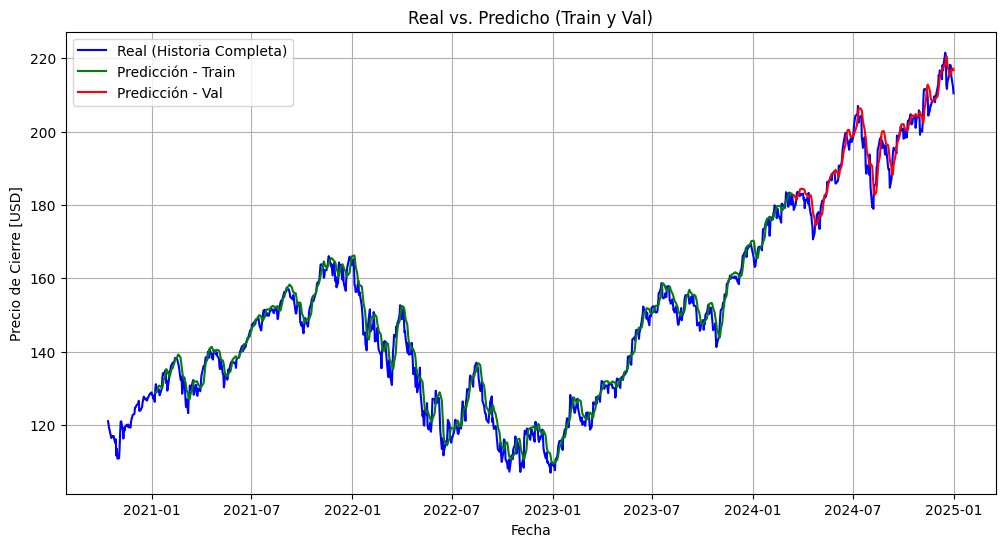

In [13]:
# Suponiendo que el modelo ya está entrenado:

# 1. Predicciones en TRAIN y en VAL
train_pred = model.predict(X_train)  # shape: (len(X_train), 1)
val_pred   = model.predict(X_val)    # shape: (len(X_val), 1)

# 2. Invertir la escala (MinMaxScaler) para obtener precios en USD
train_pred_inv = scaler.inverse_transform(train_pred)
val_pred_inv   = scaler.inverse_transform(val_pred)
y_train_inv    = scaler.inverse_transform(y_train.reshape(-1,1))
y_val_inv      = scaler.inverse_transform(y_val.reshape(-1,1))

# 3. Hallar los índices que corresponden a train y val en el DataFrame
#    - Ten en cuenta que creamos secuencias con 'window_size' días,
#      y se pierden esos primeros 'window_size' registros.
#    - X_all y y_all inician a partir de 'window_size'.
#    - Por ende, la parte train va desde [window_size, window_size + train_size)
#      y la parte val  va desde [window_size + train_size, window_size + train_size + len(y_val))

train_index_start = window_size
train_index_end   = window_size + len(y_train)  # este no es inclusivo al graficar

val_index_start   = train_index_end  # coincide con lo anterior
val_index_end     = train_index_end + len(y_val)

# Extraer los índices (fechas) reales desde df
train_dates = df.index[train_index_start:train_index_end]
val_dates   = df.index[val_index_start:val_index_end]

# 4. Gráfico unificado: Real vs. Predicted (Train) vs. Predicted (Val)
plt.figure(figsize=(12,6))

# (a) Curva real (todo el dataset)
plt.plot(df.index, df['Close'], label='Real (Historia Completa)', color='blue')

# (b) Curva predicha en Train
plt.plot(train_dates, train_pred_inv, label='Predicción - Train', color='green')

# (c) Curva predicha en Val
plt.plot(val_dates, val_pred_inv, label='Predicción - Val', color='red')

plt.title("Real vs. Predicho (Train y Val)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre [USD]")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [9]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Imaginemos que ya tienes tu X_train, y_train preparados
# con shape de (n_samples, window_size, 1) para LSTM
# y tu X_val, y_val para validación.

def build_model(hp):
    """
    Función que construye un modelo Keras
    con hiperparámetros que definimos a explorar.
    """
    model = Sequential()

    # 1. Número de neuronas en la 1ra capa LSTM
    units_lstm_1 = hp.Int("units_lstm_1", min_value=32, max_value=128, step=32)
    model.add(LSTM(units=units_lstm_1,
                   return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))

    # 2. Dropout tras la 1ra capa
    dropout_1 = hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_1))

    # 3. Número de neuronas en la 2da capa LSTM (opcional)
    units_lstm_2 = hp.Int("units_lstm_2", min_value=32, max_value=128, step=32)
    model.add(LSTM(units=units_lstm_2, return_sequences=False))

    # 4. Dropout tras la 2da capa
    dropout_2 = hp.Float("dropout_2", min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_2))

    # 5. Capa de salida
    model.add(Dense(1))

    # 6. Learning Rate
    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error'
    )
    return model

# Definir un "tuner" (ej. RandomSearch, Hyperband, BayesianOptimization)
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,         # cuántas configuraciones diferentes probar
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="stock_lstm_tuning"
)

# Iniciar búsqueda
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Entrenar con los mejores hiperparámetros
history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
    verbose=1
)

print("Mejores hiperparámetros encontrados:")
print("units_lstm_1:", best_hps.get("units_lstm_1"))
print("dropout_1:", best_hps.get("dropout_1"))
print("units_lstm_2:", best_hps.get("units_lstm_2"))
print("dropout_2:", best_hps.get("dropout_2"))
print("learning_rate:", best_hps.get("learning_rate"))


Trial 10 Complete [00h 01m 29s]
val_loss: 0.0013561954256147146

Best val_loss So Far: 0.0008793067536316812
Total elapsed time: 00h 07m 33s
Epoch 1/50
25/25 [==============================] - 11s 253ms/step - loss: 0.0286 - val_loss: 0.0042
Epoch 2/50
25/25 [==============================] - 8s 310ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 3/50
25/25 [==============================] - 4s 159ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/50
25/25 [==============================] - 5s 193ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/50
25/25 [==============================] - 3s 139ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 6/50
25/25 [==============================] - 3s 139ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/50
25/25 [==============================] - 5s 208ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 8/50
25/25 [==============================] - 4s 147ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 9/50
25/25 [==============================] - 3s 139